In [1]:
### v1.1

# Aggressive Bear Recognition Models using Transfer Learning

## 1 Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

2024-08-18 20:00:48.381031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 20:00:48.381071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 20:00:48.381694: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 20:00:48.385416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 20:00:49.030800: W tensorflow/compiler/tf2

### 1.1 Create the Dataset and Split it into Training and Validation Sets


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "new_normal_vs_aggressive_masked/"


In [3]:
validation_split = 0.2
test_split = 0.2  # Portion of data to use as test data
# seed = 42

# Load the full dataset without splitting
full_dataset = image_dataset_from_directory(directory,
                                            # shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            # seed=seed
                                           )

# Calculate the number of samples in each dataset
total_samples = len(full_dataset)
val_size = int(total_samples * validation_split)
test_size = int(total_samples * test_split)
train_size = total_samples - val_size - test_size

# Split the dataset
train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
validation_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)




Found 509 files belonging to 2 classes.


2024-08-18 20:00:59.908677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2024-08-18 20:01:00.108476: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [4]:
for i,l in full_dataset:
    print(l)

tf.Tensor([1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1], shape=(32,), dtype=int32)
tf.Tensor([1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1], shape=(32,), dtype=int32)
tf.Tensor([1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 

In [5]:
full_dataset.class_names

['aggressive_bear', 'normal_bear']

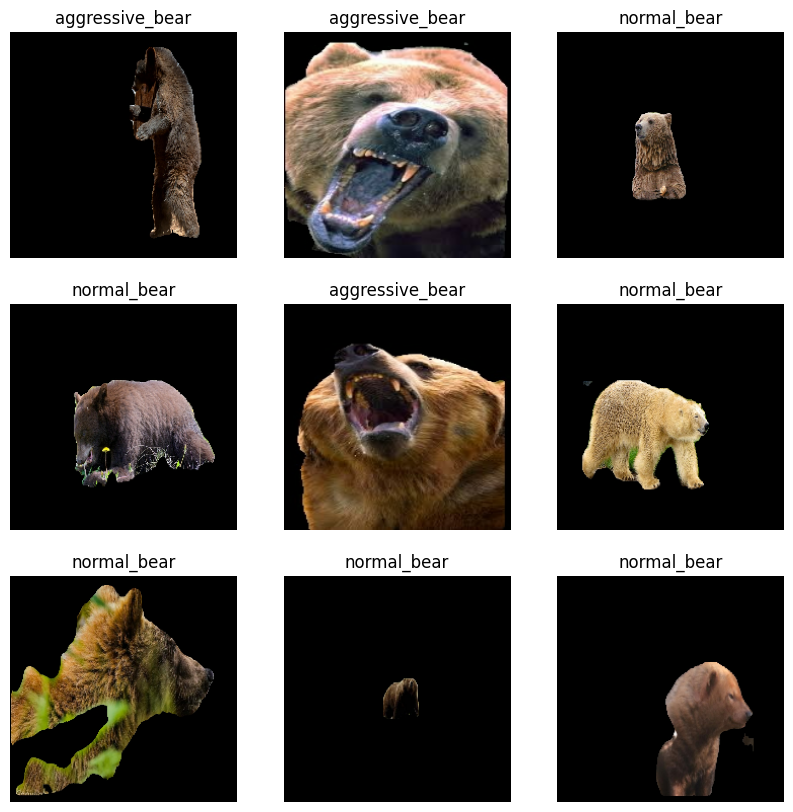

In [6]:
class_names = full_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # take(1) means take a batch which are 32 images
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [17]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

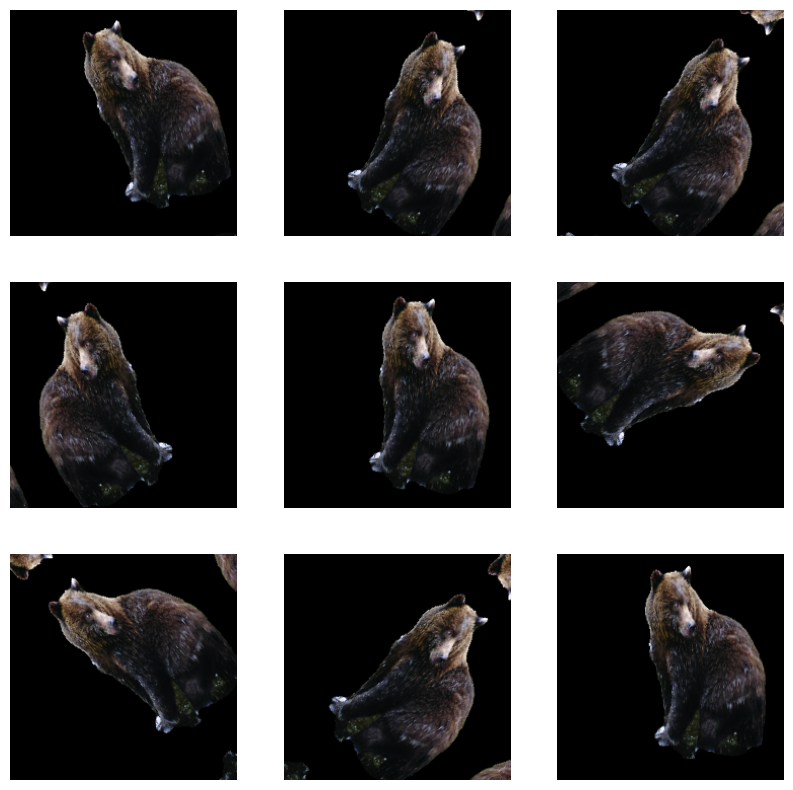

In [18]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # tf.expand_dims(first_image, 0): from (224, 224, 3) to (1, 224, 224, 3)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) 
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 2 MobileNet V2

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
##
IMG_SIZE+(3,)

(224, 224, 3)

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_v2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [19]:
def bear_model_v2(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) # (None, 224, 224, 3)
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) # (None, 224, 224, 3)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) # (None, 224, 224, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [20]:
model_v2 = bear_model_v2(IMG_SIZE, data_augmentation)

In [21]:
base_learning_rate = 0.001
model_v2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# Add callback
# callback = tf.keras.callbacks.EarlyStopping(patience=4)
initial_epochs = 50
# history_v2 = model_v2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[callback])
history_v2 = model_v2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
 3/10 [========>.....................] - ETA: 0s - loss: 0.7690 - accuracy: 0.4167 

2024-08-18 20:04:06.008177: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f02484cf730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-18 20:04:06.008216: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-08-18 20:04:06.011878: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1724004246.071142   62857 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 4s 108ms/step - loss: 0.6588 - accuracy: 0.6313 - val_loss: 0.5898 - val_accuracy: 0.7396
Epoch 2/50
10/10 [==============================] - 1s 62ms/step - loss: 0.5641 - accuracy: 0.7656 - val_loss: 0.4235 - val_accuracy: 0.8125
Epoch 3/50
10/10 [==============================] - 1s 60ms/step - loss: 0.4294 - accuracy: 0.8000 - val_loss: 0.3377 - val_accuracy: 0.8646
Epoch 4/50
10/10 [==============================] - 1s 59ms/step - loss: 0.3714 - accuracy: 0.8156 - val_loss: 0.3628 - val_accuracy: 0.8333
Epoch 5/50
10/10 [==============================] - 1s 59ms/step - loss: 0.3073 - accuracy: 0.8781 - val_loss: 0.2940 - val_accuracy: 0.8958
Epoch 6/50
10/10 [==============================] - 1s 59ms/step - loss: 0.3337 - accuracy: 0.8438 - val_loss: 0.2971 - val_accuracy: 0.8542
Epoch 7/50
10/10 [==============================] - 1s 60ms/step - loss: 0.3100 - accuracy: 0.8469 - val_loss: 0.2618 - val_accuracy: 0.8854
Epoch 8/50
10/10 [=====

Plot the training and validation accuracy:

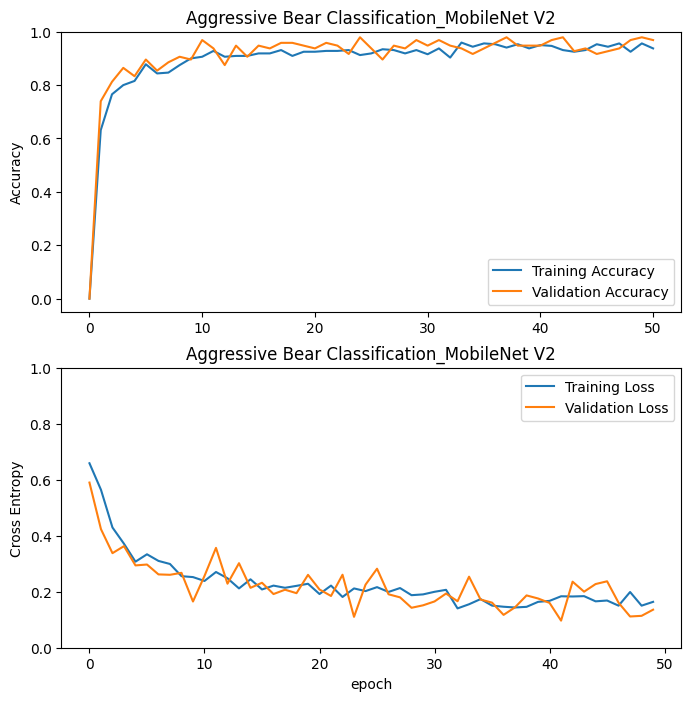

In [24]:
acc_v2 = [0.] + history_v2.history['accuracy']
val_acc_v2 = [0.] + history_v2.history['val_accuracy']

loss_v2 = history_v2.history['loss']
val_loss_v2 = history_v2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v2, label='Training Accuracy')
plt.plot(val_acc_v2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Aggressive Bear Classification_MobileNet V2')

plt.subplot(2, 1, 2)
plt.plot(loss_v2, label='Training Loss')
plt.plot(val_loss_v2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Aggressive Bear Classification_MobileNet V2')
plt.xlabel('epoch')
plt.show()

In [25]:
class_names

['aggressive_bear', 'normal_bear']

In [26]:
model_v2.evaluate(test_dataset)

3/3 [==============================] - 1s 233ms/step - loss: 0.1167 - accuracy: 0.9570


[0.11665342003107071, 0.9569892287254333]

In [27]:
l,acc = model_v2.evaluate(test_dataset)

3/3 [==============================] - 0s 19ms/step - loss: 0.1054 - accuracy: 0.9785


In [28]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_v2.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy: {average_test_accuracy}")

Average time per evaluation run: 0.2942 seconds; Average test accuracy: 0.9433691720167796


In [29]:
full_dataset.class_names

['aggressive_bear', 'normal_bear']

In [126]:
test_predicts = []
test_labels = []
from sklearn.metrics import accuracy_score
for imgs, ls in test_dataset:
    for img, l in zip(imgs, ls):
        test_labels.append(l.numpy())        
        logit = model_v2.predict(tf.expand_dims(img,0))
        prob = tf.nn.sigmoid(logit).numpy()
        predict = (prob>0.5).astype(int)
        test_predicts.append(predict)
test_predicts=np.squeeze(test_predicts)

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
print(f1_score(test_labels, test_predicts, pos_label=0))
print(recall_score(test_labels,test_predicts, pos_label=0))
print(precision_score(test_labels, test_predicts, pos_label=0))
print('\n')
print(classification_report(test_labels, test_predicts))

1/1 [==============================] - 0s 14ms/step
0.8571428571428571
0.75
1.0


              precision    recall  f1-score   support

           0       1.00      0.75      0.86        20
           1       0.94      1.00      0.97        73

    accuracy                           0.95        93
   macro avg       0.97      0.88      0.91        93
weighted avg       0.95      0.95      0.94        93



[[15  5]
 [ 0 73]]


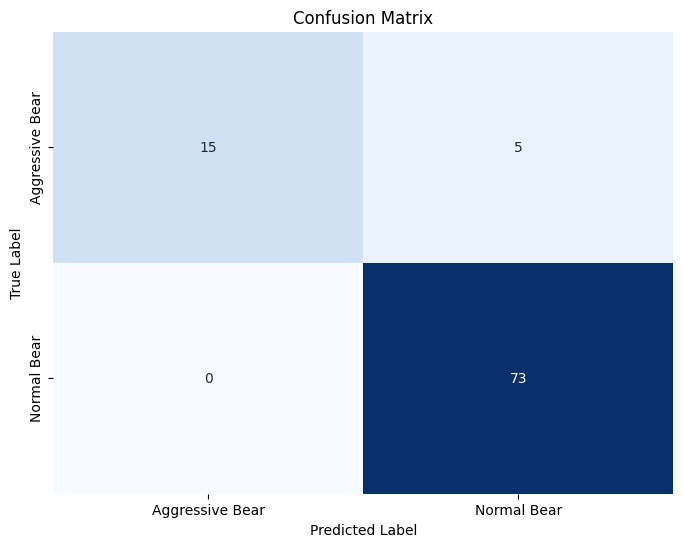

F1 Score: 0.8571428571428571
Recall: 0.75
Precision: 1.0


In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

labels = ['Aggressive Bear', 'Normal Bear']

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predicts)
print(cm)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels= labels, yticklabels=labels)


plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f'F1 Score: {f1_score(test_labels, test_predicts, pos_label=0)}')
print(f'Recall: {recall_score(test_labels, test_predicts, pos_label=0)}')
print(f'Precision: {precision_score(test_labels, test_predicts, pos_label=0)}')

## 3 MobileNetV3 Small

In [43]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [44]:
IMG_SIZE+(3,)

(224, 224, 3)

In [45]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_v3_s = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
# base_model_v3.summary()

In [49]:
def bear_model_v3_s(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV3 Small model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) # (None, 224, 224, 3)
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) # (None, 224, 224, 3)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) # (None, 224, 224, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [50]:
model_v3_s = bear_model_v3_s(IMG_SIZE, data_augmentation)

In [51]:
# callback = tf.keras.callbacks.EarlyStopping(patience=5)
base_learning_rate = 0.001
model_v3_s.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 50
# history_v3_s = model_v3_s.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[callback])
history_v3_s = model_v3_s.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
10/10 [==============================] - 3s 98ms/step - loss: 0.8796 - accuracy: 0.3063 - val_loss: 0.6710 - val_accuracy: 0.6042
Epoch 2/50
10/10 [==============================] - 1s 51ms/step - loss: 0.7167 - accuracy: 0.6594 - val_loss: 0.5912 - val_accuracy: 0.7604
Epoch 3/50
10/10 [==============================] - 1s 50ms/step - loss: 0.5967 - accuracy: 0.6969 - val_loss: 0.5452 - val_accuracy: 0.7396
Epoch 4/50
10/10 [==============================] - 1s 52ms/step - loss: 0.5241 - accuracy: 0.7219 - val_loss: 0.4328 - val_accuracy: 0.7604
Epoch 5/50
10/10 [==============================] - 1s 50ms/step - loss: 0.4644 - accuracy: 0.7625 - val_loss: 0.4592 - val_accuracy: 0.7812
Epoch 6/50
10/10 [==============================] - 1s 51ms/step - loss: 0.4221 - accuracy: 0.7937 - val_loss: 0.4099 - val_accuracy: 0.7708
Epoch 7/50
10/10 [==============================] - 1s 52ms/step - loss: 0.4403 - accuracy: 0.8062 - val_loss: 0.3876 - val_accuracy: 0.8229
Epoch 8/50
10

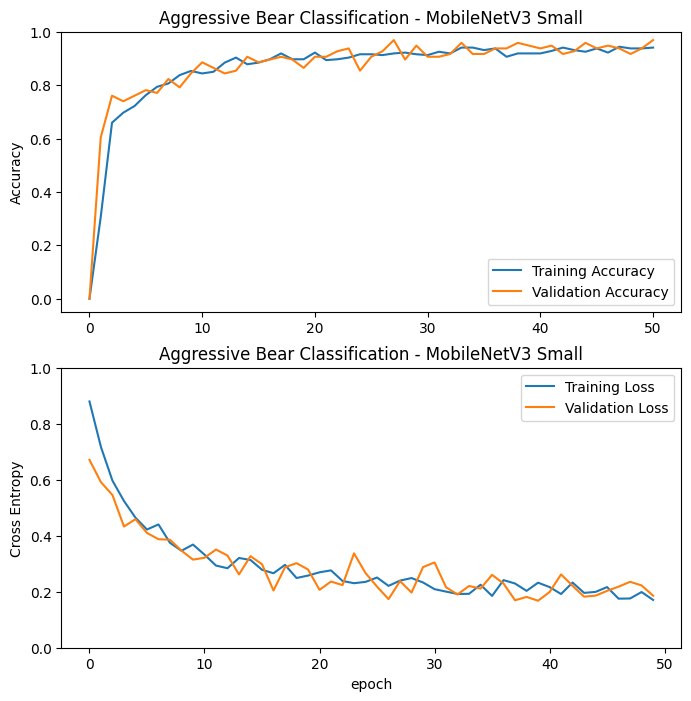

In [52]:
acc_v3_s = [0.] + history_v3_s.history['accuracy']
val_acc_v3_s = [0.] + history_v3_s.history['val_accuracy']

loss_v3_s = history_v3_s.history['loss']
val_loss_v3_s = history_v3_s.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v3_s, label='Training Accuracy')
plt.plot(val_acc_v3_s, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Aggressive Bear Classification - MobileNetV3 Small')

plt.subplot(2, 1, 2)
plt.plot(loss_v3_s, label='Training Loss')
plt.plot(val_loss_v3_s, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Aggressive Bear Classification - MobileNetV3 Small')
plt.xlabel('epoch')
plt.show()

In [53]:
model_v3_s.evaluate(test_dataset)

3/3 [==============================] - 1s 211ms/step - loss: 0.1810 - accuracy: 0.9355


[0.18103443086147308, 0.9354838728904724]

In [54]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_v3_s.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy for MobileNetV3_Small: {average_test_accuracy}")

Average time per evaluation run: 0.2705 seconds; Average test accuracy for MobileNetV3_Small: 0.9476702451705933


In [128]:
test_predicts = []
test_labels = []
from sklearn.metrics import accuracy_score
for imgs, ls in test_dataset:
    for img, l in zip(imgs, ls):
        test_labels.append(l.numpy())        
        logit = model_v3_s.predict(tf.expand_dims(img,0))
        prob = tf.nn.sigmoid(logit).numpy()
        predict = (prob>0.5).astype(int)
        test_predicts.append(predict)
test_predicts=np.squeeze(test_predicts)

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
print(f1_score(test_labels, test_predicts, pos_label=0))
print(recall_score(test_labels,test_predicts, pos_label=0))
print(precision_score(test_labels, test_predicts, pos_label=0))
print('\n')
print(classification_report(test_labels, test_predicts))

1/1 [==============================] - 0s 14ms/step
0.8292682926829268
0.7083333333333334
1.0


              precision    recall  f1-score   support

           0       1.00      0.71      0.83        24
           1       0.91      1.00      0.95        69

    accuracy                           0.92        93
   macro avg       0.95      0.85      0.89        93
weighted avg       0.93      0.92      0.92        93



[[17  7]
 [ 0 69]]


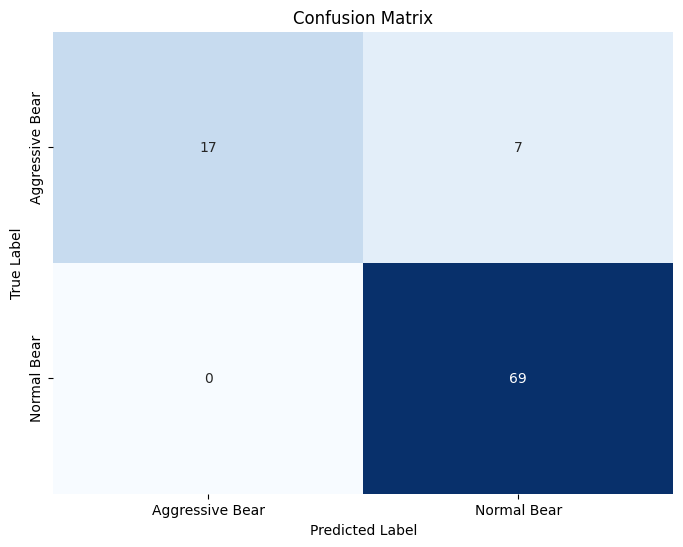

F1 Score: 0.8292682926829268
Recall: 0.7083333333333334
Precision: 1.0


In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

labels = ['Aggressive Bear', 'Normal Bear']

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predicts)
print(cm)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels= labels, yticklabels=labels)


plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f'F1 Score: {f1_score(test_labels, test_predicts, pos_label=0)}')
print(f'Recall: {recall_score(test_labels, test_predicts, pos_label=0)}')
print(f'Precision: {precision_score(test_labels, test_predicts, pos_label=0)}')

## 4 MobileNetV3 Large

In [59]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [60]:
IMG_SIZE+(3,)

(224, 224, 3)

In [61]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_v3_l = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
# base_model_v3.summary()

In [62]:
def bear_model_v3_l(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV3Large model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV3Large(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) # (None, 224, 224, 3)
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) # (None, 224, 224, 3)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) # (None, 224, 224, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [63]:
model_v3_l = bear_model_v3_l(IMG_SIZE, data_augmentation)
# callback = tf.keras.callbacks.EarlyStopping(patience=4)
base_learning_rate = 0.001
model_v3_l.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 50
# history_v3_l = model_v3_l.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[callback])
history_v3_l = model_v3_l.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
10/10 [==============================] - 4s 114ms/step - loss: 0.8786 - accuracy: 0.4812 - val_loss: 0.6776 - val_accuracy: 0.7604
Epoch 2/50
10/10 [==============================] - 1s 57ms/step - loss: 0.5698 - accuracy: 0.7688 - val_loss: 0.5056 - val_accuracy: 0.8021
Epoch 3/50
10/10 [==============================] - 1s 59ms/step - loss: 0.4398 - accuracy: 0.8031 - val_loss: 0.3133 - val_accuracy: 0.8646
Epoch 4/50
10/10 [==============================] - 1s 58ms/step - loss: 0.3745 - accuracy: 0.8094 - val_loss: 0.3028 - val_accuracy: 0.8958
Epoch 5/50
10/10 [==============================] - 1s 58ms/step - loss: 0.3955 - accuracy: 0.8313 - val_loss: 0.2650 - val_accuracy: 0.9167
Epoch 6/50
10/10 [==============================] - 1s 57ms/step - loss: 0.3420 - accuracy: 0.8594 - val_loss: 0.2873 - val_accuracy: 0.8958
Epoch 7/50
10/10 [==============================] - 1s 58ms/step - loss: 0.3256 - accuracy: 0.8594 - val_loss: 0.2744 - val_accuracy: 0.9062
Epoch 8/50
1

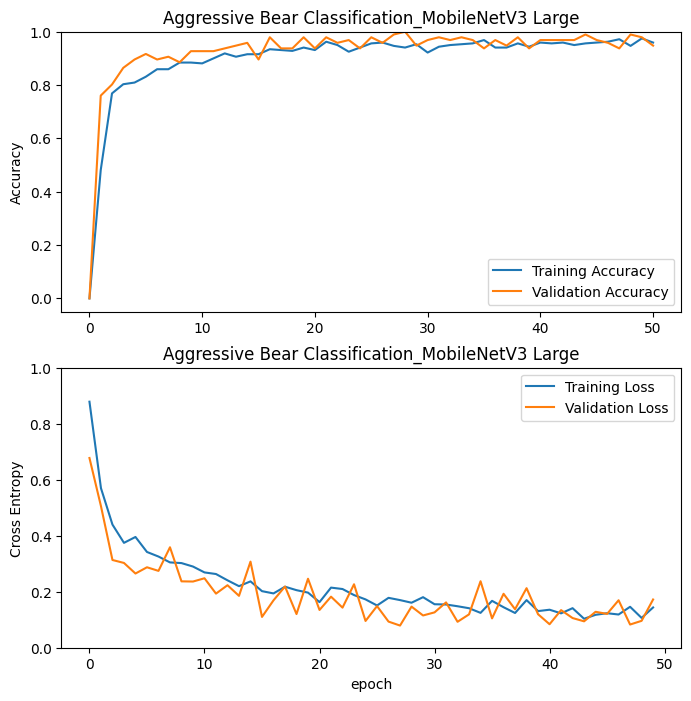

In [76]:
acc_v3_l = [0.] + history_v3_l.history['accuracy']
val_acc_v3_l = [0.] + history_v3_l.history['val_accuracy']

loss_v3_l = history_v3_l.history['loss']
val_loss_v3_l = history_v3_l.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v3_l, label='Training Accuracy')
plt.plot(val_acc_v3_l, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Aggressive Bear Classification_MobileNetV3 Large')

plt.subplot(2, 1, 2)
plt.plot(loss_v3_l, label='Training Loss')
plt.plot(val_loss_v3_l, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Aggressive Bear Classification_MobileNetV3 Large')
plt.xlabel('epoch')
plt.show()

In [77]:
model_v3_l.evaluate(test_dataset)

3/3 [==============================] - 1s 225ms/step - loss: 0.1771 - accuracy: 0.9462


[0.17705067992210388, 0.9462365508079529]

In [78]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_v3_l.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy for MobileNetV3 Large: {average_test_accuracy}")

Average time per evaluation run: 0.2911 seconds; Average test accuracy for MobileNetV3 Large: 0.9698924640814464


In [131]:
test_predicts = []
test_labels = []
from sklearn.metrics import accuracy_score
for imgs, ls in test_dataset:
    for img, l in zip(imgs, ls):
        test_labels.append(l.numpy())        
        logit = model_v3_l.predict(tf.expand_dims(img,0))
        prob = tf.nn.sigmoid(logit).numpy()
        predict = (prob>0.5).astype(int)
        test_predicts.append(predict)
test_predicts=np.squeeze(test_predicts)

1/1 [==============================] - 0s 14ms/step


In [134]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
print(f1_score(test_labels, test_predicts, pos_label=0))
print(recall_score(test_labels,test_predicts, pos_label=0))
print(precision_score(test_labels, test_predicts, pos_label=0))
print('\n')
print(classification_report(test_labels, test_predicts))

0.9090909090909091
0.8333333333333334
1.0


              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.96      1.00      0.98        75

    accuracy                           0.97        93
   macro avg       0.98      0.92      0.94        93
weighted avg       0.97      0.97      0.97        93



[[15  3]
 [ 0 75]]


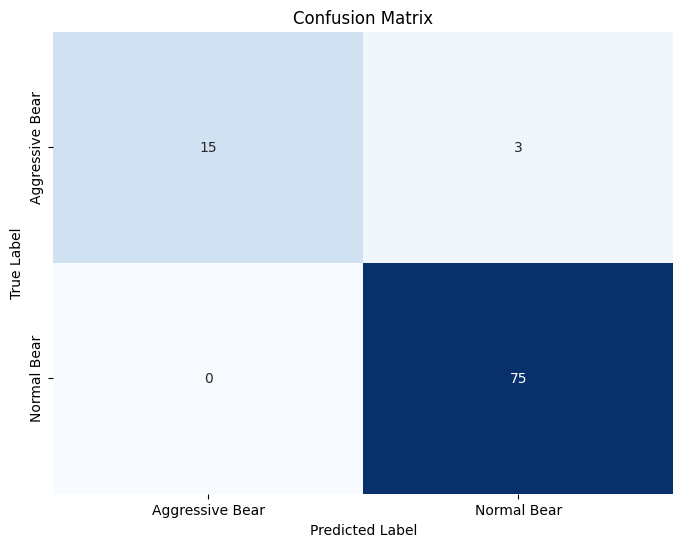

F1 Score: 0.9090909090909091
Recall: 0.8333333333333334
Precision: 1.0


In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

labels = ['Aggressive Bear', 'Normal Bear']

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predicts)
print(cm)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
#             xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels= labels, yticklabels=labels)


plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f'F1 Score: {f1_score(test_labels, test_predicts, pos_label=0)}')
print(f'Recall: {recall_score(test_labels, test_predicts, pos_label=0)}')
print(f'Precision: {precision_score(test_labels, test_predicts, pos_label=0)}')

## 5 Compare 3 models performance 

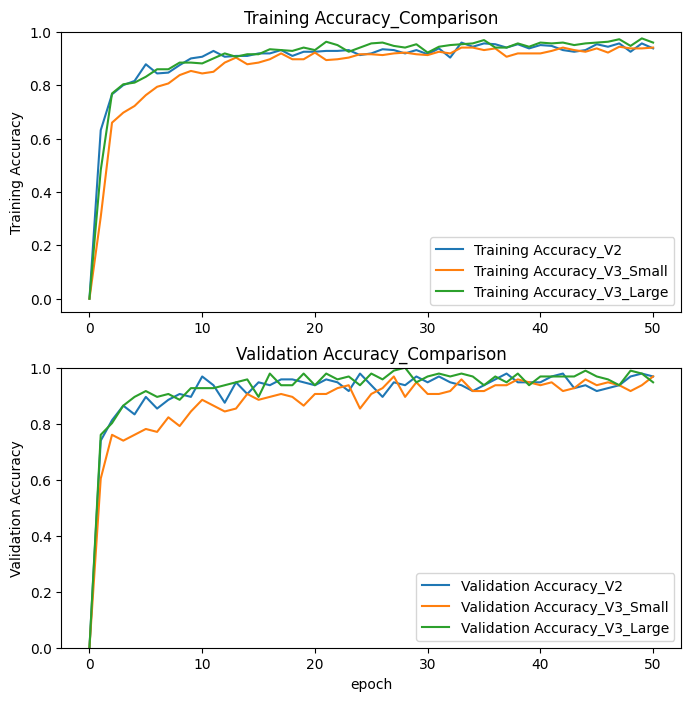

In [102]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v2, label='Training Accuracy_V2')
plt.plot(acc_v3_s, label='Training Accuracy_V3_Small')
plt.plot(acc_v3_l, label='Training Accuracy_V3_Large')

plt.legend(loc='lower right')
plt.ylabel('Training Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy_Comparison')

plt.subplot(2, 1, 2)
plt.plot(val_acc_v2, label='Validation Accuracy_V2')
plt.plot(val_acc_v3_s, label='Validation Accuracy_V3_Small')
plt.plot(val_acc_v3_l, label='Validation Accuracy_V3_Large')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.ylim([0,1.0])
plt.title('Validation Accuracy_Comparison')
plt.xlabel('epoch')
plt.show()

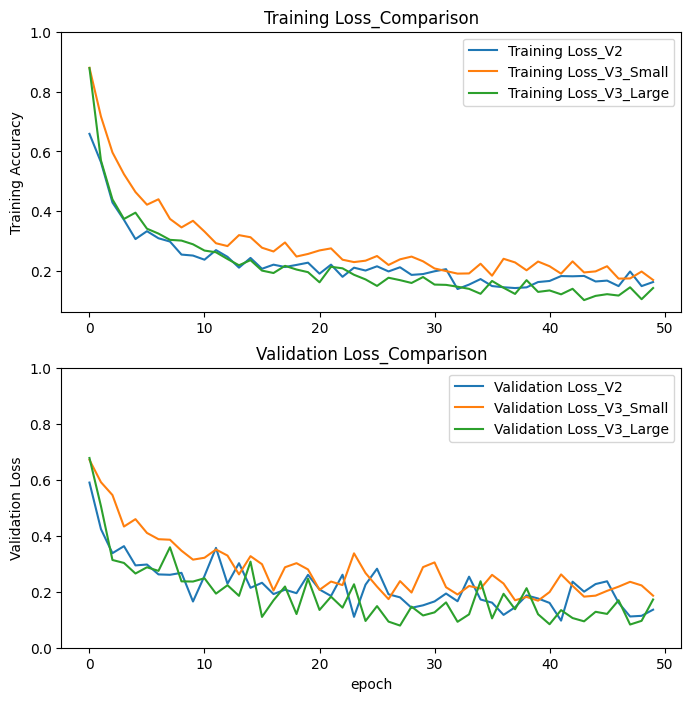

In [103]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss_v2, label='Training Loss_V2')
plt.plot(loss_v3_s, label='Training Loss_V3_Small')
plt.plot(loss_v3_l, label='Training Loss_V3_Large')

plt.legend(loc='upper right')
plt.ylabel('Training Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Loss_Comparison')

plt.subplot(2, 1, 2)
plt.plot(val_loss_v2, label='Validation Loss_V2')
plt.plot(val_loss_v3_s, label='Validation Loss_V3_Small')
plt.plot(val_loss_v3_l, label='Validation Loss_V3_Large')
plt.legend(loc='upper right')
plt.ylabel('Validation Loss')
plt.ylim([0,1.0])
plt.title('Validation Loss_Comparison')
plt.xlabel('epoch')
plt.show()

## 6 Efficient Net

In [104]:
def bear_model_ef(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,  # Exclude the final classification layers
    weights='imagenet',  # Use ImageNet pre-trained weights
    input_shape=(224, 224, 3)  
)
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) 

    # data preprocessing using the same weights the model was trained on
    x = tf.keras.applications.efficientnet.preprocess_input(x) # (None, 224, 224, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [105]:
model_ef = bear_model_ef(IMG_SIZE, data_augmentation)
base_learning_rate = 0.001
model_ef.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [106]:
history_ef = model_ef.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50  
)


Epoch 1/50
10/10 [==============================] - 5s 147ms/step - loss: 0.6301 - accuracy: 0.5094 - val_loss: 0.4658 - val_accuracy: 0.8229
Epoch 2/50
10/10 [==============================] - 1s 69ms/step - loss: 0.4361 - accuracy: 0.8281 - val_loss: 0.4082 - val_accuracy: 0.8646
Epoch 3/50
10/10 [==============================] - 1s 67ms/step - loss: 0.3718 - accuracy: 0.8750 - val_loss: 0.3096 - val_accuracy: 0.9375
Epoch 4/50
10/10 [==============================] - 1s 68ms/step - loss: 0.3414 - accuracy: 0.8781 - val_loss: 0.4389 - val_accuracy: 0.8542
Epoch 5/50
10/10 [==============================] - 1s 68ms/step - loss: 0.3324 - accuracy: 0.8656 - val_loss: 0.3528 - val_accuracy: 0.8854
Epoch 6/50
10/10 [==============================] - 1s 68ms/step - loss: 0.2759 - accuracy: 0.9125 - val_loss: 0.2611 - val_accuracy: 0.9375
Epoch 7/50
10/10 [==============================] - 1s 67ms/step - loss: 0.2519 - accuracy: 0.9250 - val_loss: 0.2735 - val_accuracy: 0.9167
Epoch 8/50
1

In [107]:
model_ef.evaluate(test_dataset)

3/3 [==============================] - 1s 161ms/step - loss: 0.1263 - accuracy: 0.9570


[0.1262539029121399, 0.9569892287254333]

In [108]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_ef.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy: {average_test_accuracy}")

Average time per evaluation run: 0.3146 seconds; Average test accuracy: 0.9637992719809214


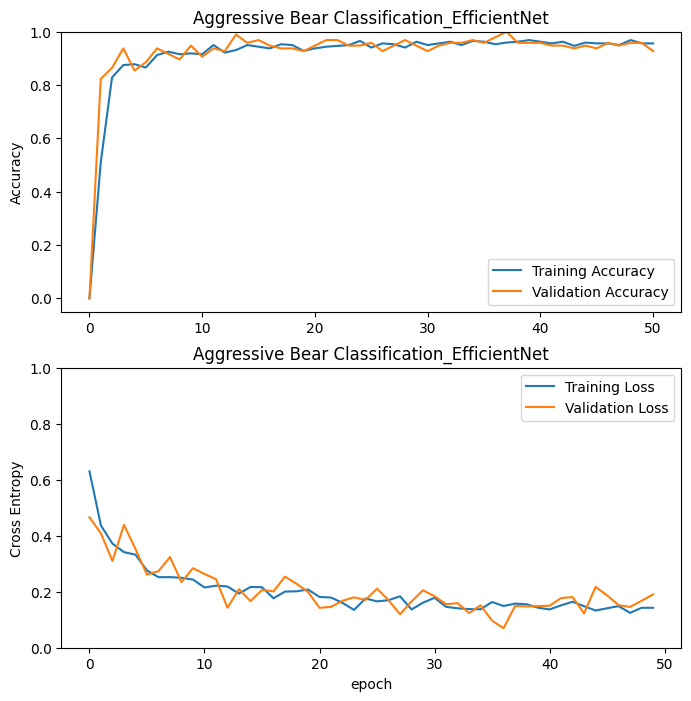

In [109]:
acc_ef = [0.] + history_ef.history['accuracy']
val_acc_ef = [0.] + history_ef.history['val_accuracy']

loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_ef, label='Training Accuracy')
plt.plot(val_acc_ef, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Aggressive Bear Classification_EfficientNet')

plt.subplot(2, 1, 2)
plt.plot(loss_ef, label='Training Loss')
plt.plot(val_loss_ef, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Aggressive Bear Classification_EfficientNet')
plt.xlabel('epoch')
plt.show()

In [136]:
test_predicts = []
test_labels = []
from sklearn.metrics import accuracy_score
for imgs, ls in test_dataset:
    for img, l in zip(imgs, ls):
        test_labels.append(l.numpy())        
        logit = model_ef.predict(tf.expand_dims(img,0))
        prob = tf.nn.sigmoid(logit).numpy()
        predict = (prob>0.5).astype(int)
        test_predicts.append(predict)
test_predicts=np.squeeze(test_predicts)

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
print(f1_score(test_labels, test_predicts, pos_label=0))
print(recall_score(test_labels,test_predicts, pos_label=0))
print(precision_score(test_labels, test_predicts, pos_label=0))
print('\n')
print(classification_report(test_labels, test_predicts))

1/1 [==============================] - 0s 16ms/step
0.8
0.6666666666666666
1.0


              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.95      1.00      0.98        81

    accuracy                           0.96        93
   macro avg       0.98      0.83      0.89        93
weighted avg       0.96      0.96      0.95        93



[[ 8  4]
 [ 0 81]]


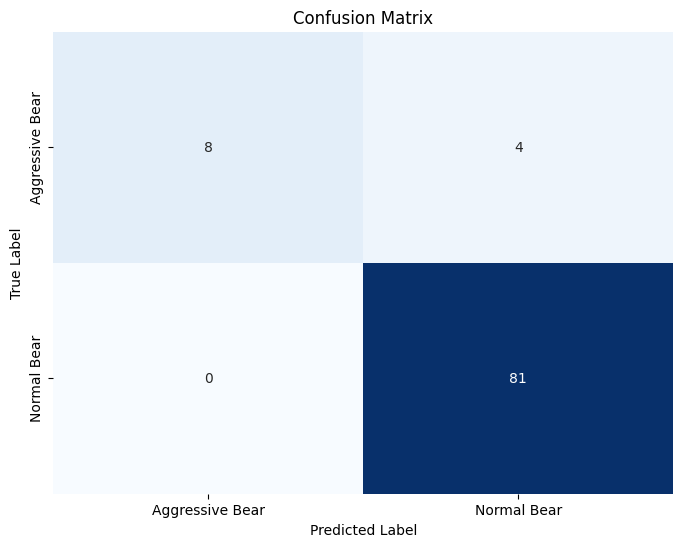

F1 Score: 0.8
Recall: 0.6666666666666666
Precision: 1.0


In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

labels = ['Aggressive Bear', 'Normal Bear']

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predicts)
print(cm)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels= labels, yticklabels=labels)


plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f'F1 Score: {f1_score(test_labels, test_predicts, pos_label=0)}')
print(f'Recall: {recall_score(test_labels, test_predicts, pos_label=0)}')
print(f'Precision: {precision_score(test_labels, test_predicts, pos_label=0)}')

## 7 Efficient Net V2

In [112]:
def bear_model_ef2(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,  # Exclude the final classification layers
    weights='imagenet',  # Use ImageNet pre-trained weights
    input_shape=(224, 224, 3)  
)
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) 

    # data preprocessing using the same weights the model was trained on
    x = tf.keras.applications.efficientnet_v2.preprocess_input(x) # (None, 224, 224, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [113]:
model_ef2 = bear_model_ef(IMG_SIZE, data_augmentation)
base_learning_rate = 0.001
model_ef2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [114]:
history_ef2 = model_ef2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50  
)

Epoch 1/50
10/10 [==============================] - 5s 146ms/step - loss: 0.5663 - accuracy: 0.6125 - val_loss: 0.4223 - val_accuracy: 0.8333
Epoch 2/50
10/10 [==============================] - 1s 69ms/step - loss: 0.4603 - accuracy: 0.8156 - val_loss: 0.3775 - val_accuracy: 0.8542
Epoch 3/50
10/10 [==============================] - 1s 69ms/step - loss: 0.3722 - accuracy: 0.8813 - val_loss: 0.3837 - val_accuracy: 0.8854
Epoch 4/50
10/10 [==============================] - 1s 69ms/step - loss: 0.3543 - accuracy: 0.8500 - val_loss: 0.3611 - val_accuracy: 0.9062
Epoch 5/50
10/10 [==============================] - 1s 67ms/step - loss: 0.3040 - accuracy: 0.9031 - val_loss: 0.2563 - val_accuracy: 0.9479
Epoch 6/50
10/10 [==============================] - 1s 69ms/step - loss: 0.2904 - accuracy: 0.9156 - val_loss: 0.2491 - val_accuracy: 0.9688
Epoch 7/50
10/10 [==============================] - 1s 70ms/step - loss: 0.3040 - accuracy: 0.8906 - val_loss: 0.2592 - val_accuracy: 0.9167
Epoch 8/50
1

In [73]:
model_ef2.evaluate(test_dataset)

3/3 [==============================] - 0s 27ms/step - loss: 0.0601 - accuracy: 0.9892


[0.06006329506635666, 0.9892473220825195]

In [115]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_ef2.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy: {average_test_accuracy}")

Average time per evaluation run: 0.3150 seconds; Average test accuracy: 0.9627240041891734


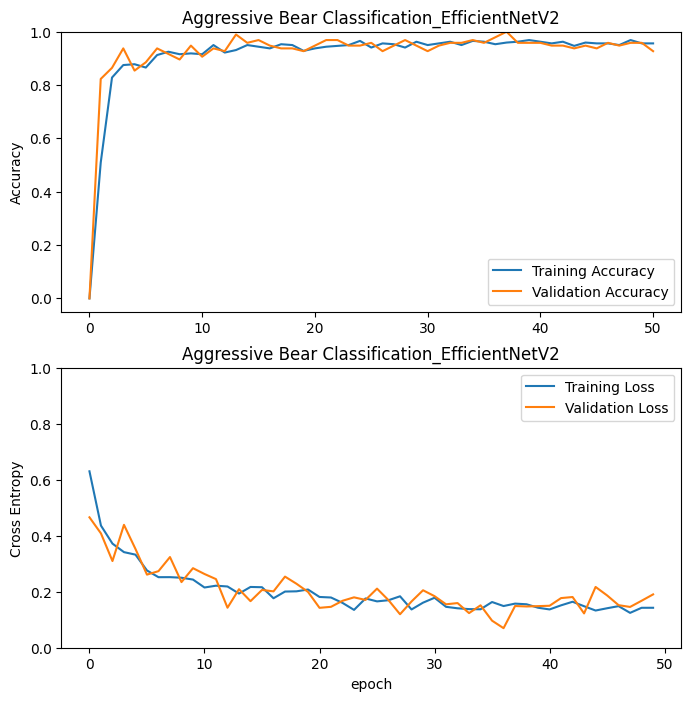

In [117]:
acc_ef = [0.] + history_ef.history['accuracy']
val_acc_ef = [0.] + history_ef.history['val_accuracy']

loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_ef, label='Training Accuracy')
plt.plot(val_acc_ef, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Aggressive Bear Classification_EfficientNetV2')

plt.subplot(2, 1, 2)
plt.plot(loss_ef, label='Training Loss')
plt.plot(val_loss_ef, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Aggressive Bear Classification_EfficientNetV2')
plt.xlabel('epoch')
plt.show()

In [138]:
test_predicts = []
test_labels = []
from sklearn.metrics import accuracy_score
for imgs, ls in test_dataset:
    for img, l in zip(imgs, ls):
        test_labels.append(l.numpy())        
        logit = model_ef2.predict(tf.expand_dims(img,0))
        prob = tf.nn.sigmoid(logit).numpy()
        predict = (prob>0.5).astype(int)
        test_predicts.append(predict)
test_predicts=np.squeeze(test_predicts)

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
print(f1_score(test_labels, test_predicts, pos_label=0))
print(recall_score(test_labels,test_predicts, pos_label=0))
print(precision_score(test_labels, test_predicts, pos_label=0))
print('\n')
print(classification_report(test_labels, test_predicts))

1/1 [==============================] - 0s 16ms/step
0.9090909090909091
0.8333333333333334
1.0


              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.96      1.00      0.98        75

    accuracy                           0.97        93
   macro avg       0.98      0.92      0.94        93
weighted avg       0.97      0.97      0.97        93



[[15  3]
 [ 0 75]]


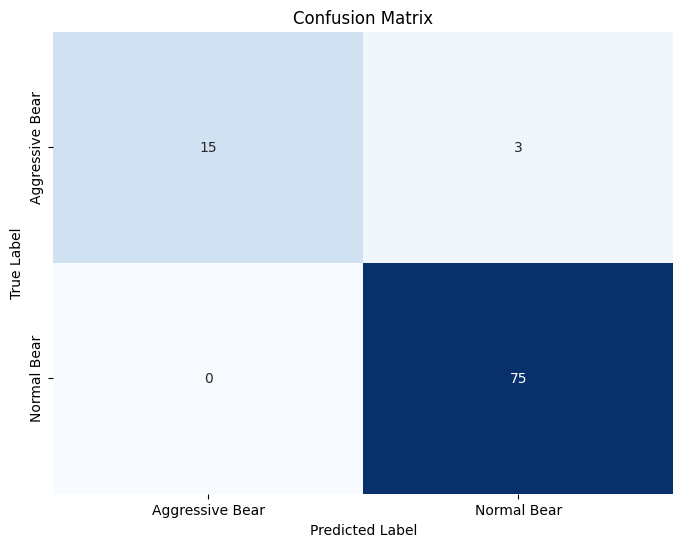

F1 Score: 0.9090909090909091
Recall: 0.8333333333333334
Precision: 1.0


In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

labels = ['Aggressive Bear', 'Normal Bear']

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predicts)
print(cm)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels= labels, yticklabels=labels)


plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f'F1 Score: {f1_score(test_labels, test_predicts, pos_label=0)}')
print(f'Recall: {recall_score(test_labels, test_predicts, pos_label=0)}')
print(f'Precision: {precision_score(test_labels, test_predicts, pos_label=0)}')

## 8 Compare 5 models performance 

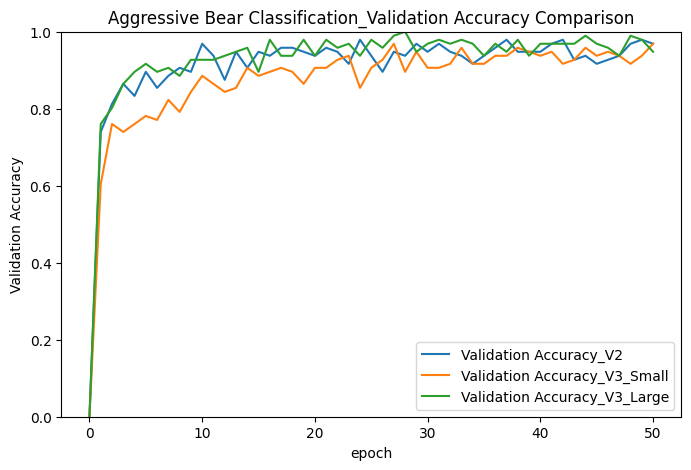

In [120]:

plt.figure(figsize=(8,5))
plt.plot(val_acc_v2, label='Validation Accuracy_V2')
plt.plot(val_acc_v3_s, label='Validation Accuracy_V3_Small')
plt.plot(val_acc_v3_l, label='Validation Accuracy_V3_Large')

plt.ylim([0,1.0])


# plt.plot( df['  metrics/accuracy_top1'], label = 'Validation Accuracy YOLO')
# plt.grid()

plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.title('Aggressive Bear Classification_Validation Accuracy Comparison')
plt.xlabel('epoch')
plt.show()

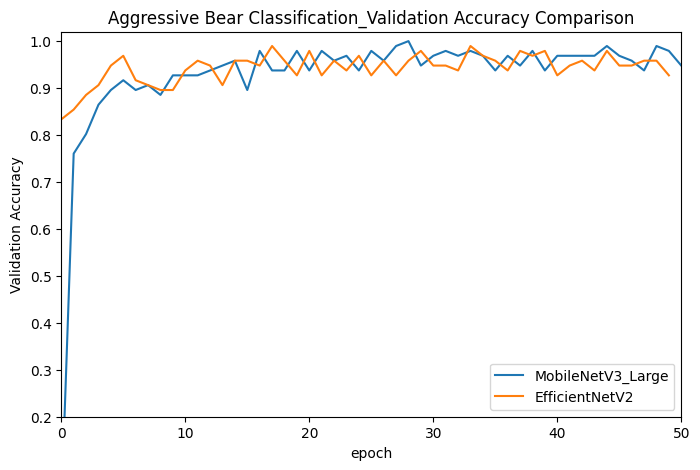

In [121]:
plt.figure(figsize=(8,5))
# plt.plot(val_acc_v2, label='MobileNetV2')
# plt.plot(val_acc_v3_s, label='MobileNetV3_Small')
plt.plot(val_acc_v3_l, label='MobileNetV3_Large')
# plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")
plt.plot(history_ef2.history['val_accuracy'], label="EfficientNetV2")

plt.ylim([0.2,1.02])
plt.xlim([0,50])

plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.title('Aggressive Bear Classification_Validation Accuracy Comparison')
plt.xlabel('epoch')
plt.show()

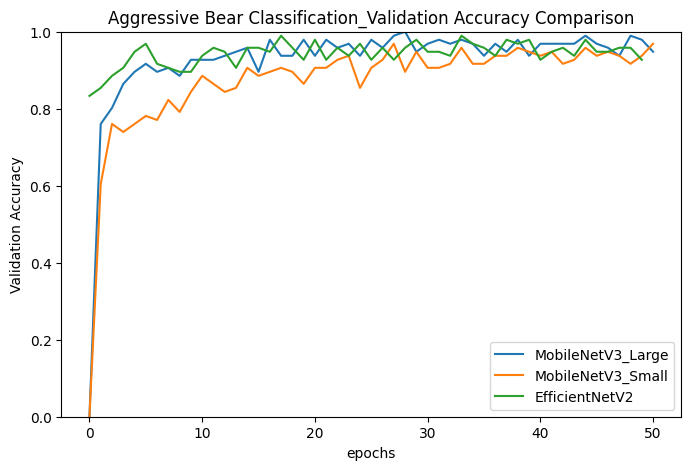

In [122]:
plt.figure(figsize=(8,5))
# plt.plot(val_acc_v2, label='Validation Accuracy_V2')
# plt.plot(val_acc_v3_s, label='Validation Accuracy_V3_Small')
plt.plot(val_acc_v3_l, label='MobileNetV3_Large')
# plt.plot(val_acc_v2, label='MobileNetV2')
plt.plot(val_acc_v3_s, label='MobileNetV3_Small')
# plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")
plt.plot(history_ef2.history['val_accuracy'], label="EfficientNetV2")
plt.ylim([0,1.0])

# plt.plot( df['  metrics/accuracy_top1'], label = 'Validation Accuracy YOLO')
# plt.grid()
plt.title('Aggressive Bear Classification_Validation Accuracy Comparison')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.show()

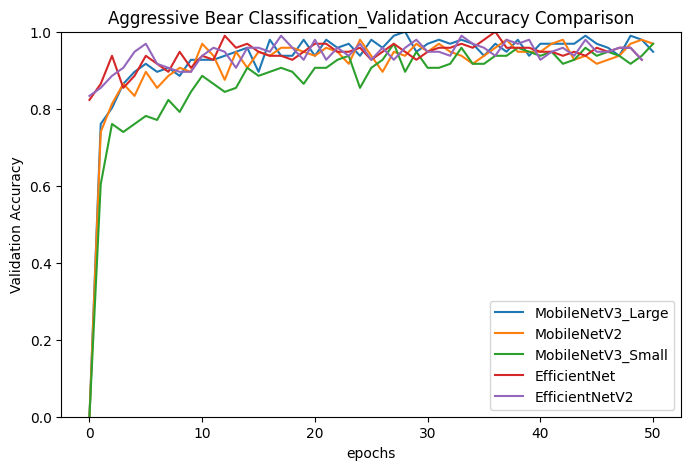

In [123]:
plt.figure(figsize=(8,5))

plt.plot(val_acc_v3_l, label='MobileNetV3_Large')
plt.plot(val_acc_v2, label='MobileNetV2')
plt.plot(val_acc_v3_s, label='MobileNetV3_Small')
plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")
plt.plot(history_ef2.history['val_accuracy'], label="EfficientNetV2")
plt.ylim([0,1.0])

# plt.plot( df['  metrics/accuracy_top1'], label = 'Validation Accuracy YOLO')
# plt.grid()
plt.title('Aggressive Bear Classification_Validation Accuracy Comparison')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.show()

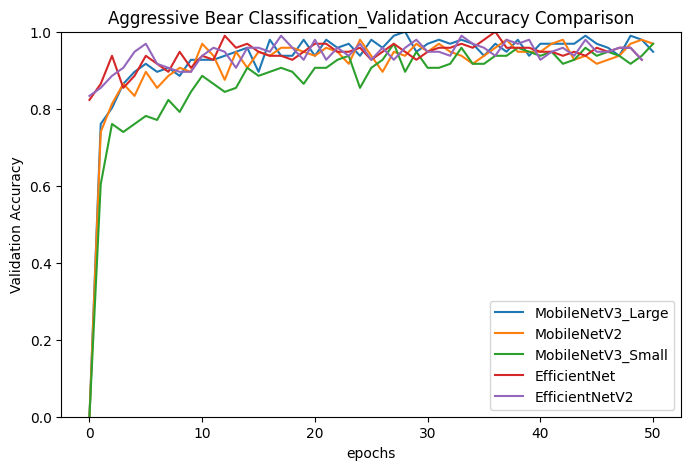

In [124]:
plt.figure(figsize=(8,5))

plt.plot(val_acc_v3_l, label='MobileNetV3_Large')
plt.plot(val_acc_v2, label='MobileNetV2')
plt.plot(val_acc_v3_s, label='MobileNetV3_Small')
plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")
plt.plot(history_ef2.history['val_accuracy'], label="EfficientNetV2")
plt.ylim([0,1.0])

# plt.plot( df['  metrics/accuracy_top1'], label = 'Validation Accuracy YOLO')

plt.title('Aggressive Bear Classification_Validation Accuracy Comparison')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.show()

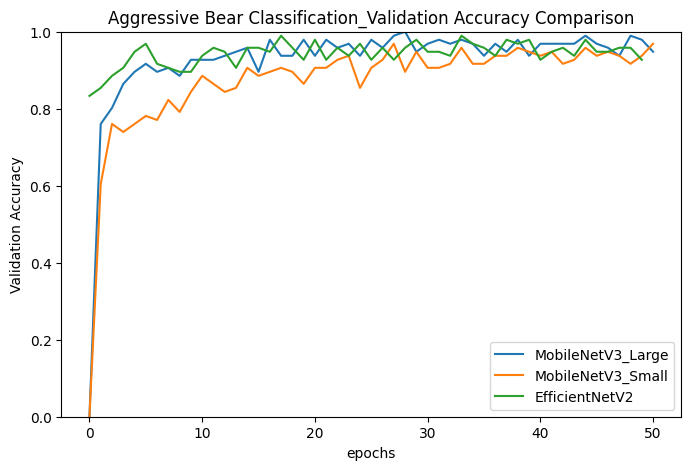

In [125]:
plt.figure(figsize=(8,5))

plt.plot(val_acc_v3_l, label='MobileNetV3_Large')
# plt.plot(val_acc_v2, label='MobileNetV2')
plt.plot(val_acc_v3_s, label='MobileNetV3_Small')
# plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")
plt.plot(history_ef2.history['val_accuracy'], label="EfficientNetV2")
plt.ylim([0,1.0])

# plt.plot( df['  metrics/accuracy_top1'], label = 'Validation Accuracy YOLO')

plt.title('Aggressive Bear Classification_Validation Accuracy Comparison')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.show()